In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive")
os.chdir("UCSC COSMOS 2023")
os.chdir("cosmos group project")

!ls

Mounted at /content/drive
 actualVpredict20221231.csv		     'loadgluonts - 2023data.ipynb'
 actualVpredict.csv			      loadgluonts.ipynb
 HistoricalEMSHourlyLoad-2020.xlsx	      sandiego-20200101-20221231.csv
 HistoricalEMSHourlyLoad-2021.xlsx	      sandiego-20230101-20230131.csv
 HistoricalEMSHourlyLoad-2022.xlsx	      sandiego-20230101-20230701.csv
 HistoricalEMSHourlyLoadforJanuary2023.xlsx   serialized_models
 lightning_logs				      trian-GluonTS.ipynb
 loadgluonts-2022-12-31-test.ipynb


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [4]:
#Load Data

EMSLoad2020 = pd.read_excel("./HistoricalEMSHourlyLoad-2020.xlsx")
EMSLoad2021 = pd.read_excel("./HistoricalEMSHourlyLoad-2021.xlsx")
EMSLoad2022 = pd.read_excel("./HistoricalEMSHourlyLoad-2022.xlsx")

WeatherData = pd.read_csv("./sandiego-20200101-20221231.csv")

In [5]:
#Combine EMS Loads
EMSLoads = pd.concat([EMSLoad2020, EMSLoad2021, EMSLoad2022])
EMSLoads.drop(EMSLoads.columns.difference(['Date','HR', 'SDGE']), 1, inplace=True)
EMSLoads = EMSLoads.reset_index(drop=True)

<ipython-input-5-53c9c1e84489>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  EMSLoads.drop(EMSLoads.columns.difference(['Date','HR', 'SDGE']), 1, inplace=True)


In [6]:
timearr  = []

for index, row in EMSLoads.iterrows():
    time = ((row["Date"].to_pydatetime()) + timedelta(hours=(row["HR"]-1)))
    timestring = time.strftime("%Y-%m-%dT%H:%M") #iso8601 without the seconds
    timearr.append(timestring)

EMSLoads["time"] = timearr
EMSLoads.drop(EMSLoads.columns.difference(['time', 'SDGE']), 1, inplace=True)

<ipython-input-6-6dd690bf7e1d>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  EMSLoads.drop(EMSLoads.columns.difference(['time', 'SDGE']), 1, inplace=True)


In [7]:
CombinedData = pd.merge(
     EMSLoads, WeatherData, on=["time"]
 )

In [8]:
CombinedData['time'] = pd.to_datetime(CombinedData['time'])
CombinedData.set_index("time", inplace = True)

In [9]:
#RUNNING MULTIPLE TIMES ON THE SAME DATAFRAME WILL CAUSE EXTRA VALUES, TO RUN AGAIN RE-RUN
#  THE COMBINED DATA CELL

##This cell block fills up missing/empty rows

prevind = pd.to_datetime("2019-12-31 23:00:00")
CombinedData = CombinedData[~CombinedData.index.duplicated(keep='first')]

for ind in CombinedData.index:
    #print(ind)
    #print(prevind + pd.Timedelta(hours=1))
    nexttime = (prevind + pd.Timedelta(hours=1))
    if(nexttime!=ind):
        print(nexttime)
        CombinedData.loc[nexttime] = [np.NaN] * CombinedData.shape[1]
        #CombinedData.append(pd.Series(name=nexttime))

    prevind = ind

CombinedData = CombinedData.ffill() #fill up values

<ipython-input-9-10e77be298d0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CombinedData.loc[nexttime] = [np.NaN] * CombinedData.shape[1]
<ipython-input-9-10e77be298d0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CombinedData.loc[nexttime] = [np.NaN] * CombinedData.shape[1]


2020-03-08 02:00:00
2021-03-14 01:00:00
2022-03-13 01:00:00


In [10]:
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf

In [11]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.model.predictor import Predictor
from pathlib import Path


/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [12]:
dataset = PandasDataset(CombinedData, target="SDGE", freq="1H")

In [33]:
#try for final day
training_data, test_gen = split(dataset, offset=-24)
test_data = test_gen.generate_instances(prediction_length=12, windows=2)


In [22]:
model = Predictor.deserialize(Path('./serialized_models/version_10'))

In [34]:
forecasts = list(model.predict(test_data.input))

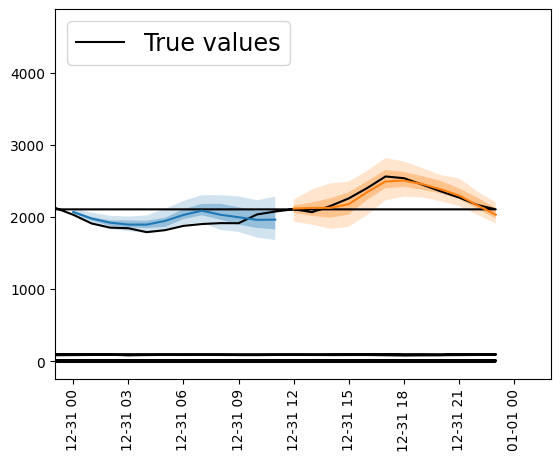

In [35]:

# Plot predictions
plt.plot(CombinedData[:], color="black")

#for last day of 2022
plt.xlim(xmin=pd.to_datetime('2022-12-30 23:00'))
plt.xlim(xmax=pd.to_datetime('2023-1-1 2:00'))

plt.xticks(rotation=90)


for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")


In [17]:
actualVpredict = pd.DataFrame()

actualListDF = []
predictListDF = []
dateListDF = []
for forecast in forecasts:
    dateList = forecast.index.to_timestamp().tolist()
    medianValues = forecast.quantile(0.5)

    if(len(dateList) != len(medianValues)):
        print("ERROR, DATELIST IS NOT THE SAME LEN AS MEDIANVALUES")

    for i in range(len(dateList)):
        actualListDF.append(CombinedData['SDGE'][pd.to_datetime(dateList[i])])
        predictListDF.append(medianValues[i])
        dateListDF.append(pd.to_datetime(dateList[i]))

actualVpredict["time"] = dateListDF
actualVpredict["prediction"] = predictListDF
actualVpredict["actual"] = actualListDF

actualVpredict.set_index("time", inplace = True)

In [18]:
actualVpredict

,prediction,actual
time,,
2022-12-31 00:00:00,2074.298340,2035.80
2022-12-31 01:00:00,1985.149658,1914.97
2022-12-31 02:00:00,1924.264648,1857.70
2022-12-31 03:00:00,1903.784058,1848.86
2022-12-31 04:00:00,1913.112915,1794.54
2022-12-31 05:00:00,1947.327637,1821.88
2022-12-31 06:00:00,2047.552856,1881.39
2022-12-31 07:00:00,2088.272949,1907.10
2022-12-31 08:00:00,2063.016357,1919.67


In [19]:
#actualVpredict.to_csv('actualVpredict20221231.csv', encoding='utf-8')

In [20]:
actualVpredict.shape

(12, 2)